In [226]:
import numpy as np
import pandas as pd
import requests
from xml.etree import ElementTree
import tqdm
import matplotlib.pyplot as plt

In [227]:
def strtobool(val):
    """Convert a string representation of truth to true (1) or false (0).
    True values are 'y', 'yes', 't', 'true', 'on', and '1'; false values
    are 'n', 'no', 'f', 'false', 'off', and '0'.  Raises ValueError if
    'val' is anything else.
    """
    val = val.lower()
    if val in ('y', 'yes', 't', 'true', 'on', '1'):
        return 1
    elif val in ('n', 'no', 'f', 'false', 'off', '0'):
        return 0
    else:
        raise ValueError("invalid truth value %r" % (val,))

In [228]:
NODES_FILE = "nodes.csv"
BASIC_OPENSTREETMAP_API = "https://www.openstreetmap.org/api/0.6/"
OPENSTREETMAP_NODE_API = BASIC_OPENSTREETMAP_API + "node/"
OPENSTREETMAP_NODES_API = BASIC_OPENSTREETMAP_API + "nodes?nodes="

In [229]:
nodes = pd.read_csv(NODES_FILE)

In [230]:
nodes.head()

,Id,node_start,node_finish,distance,speed
0,-2627062893189810184,10980432,2133368107,17.414917,32.0
1,-2627062893189810184,10980433,5212387954,17.186539,26.0
2,-2627062893189810184,10980445,5221700954,28.513481,26.0
3,-2627062893189810184,10980498,10980445,154.266122,25.0
4,-2627062893189810184,10980647,1986137911,8.542824,29.0


In [231]:
nodes.describe()

,Id,node_start,node_finish,distance,speed
count,4.802910e+05,4.802910e+05,4.802910e+05,480291.000000,476307.000000
mean,1.325593e+17,3.831874e+09,3.831719e+09,37.992984,31.293073
std,5.329873e+18,2.702820e+09,2.702986e+09,43.718081,10.131391
min,-9.221524e+18,1.098042e+07,1.098042e+07,0.076575,5.000000
25%,-4.399445e+18,1.570777e+09,1.570777e+09,9.548104,24.000000
50%,1.556848e+17,4.439628e+09,4.439628e+09,22.237880,30.000000
75%,4.817189e+18,5.214945e+09,5.215058e+09,50.181445,37.000000
max,9.222287e+18,8.952487e+09,8.952487e+09,1374.510868,100.000000


In [232]:
sum(nodes['speed'].isna())

3984

In [233]:
nodes_start_unique = nodes['node_start'].unique()
nodes_finish_unique = nodes['node_finish'].unique()

In [234]:
nodes_unique = np.unique(np.append(nodes_start_unique, nodes_finish_unique))

In [235]:
nodes_unique

array([  10980417,   10980418,   10980419, ..., 8952486106, 8952486393,
       8952486639], dtype=int64)

In [236]:
len(nodes_unique)

20368

In [237]:
nodes_info = pd.DataFrame({'node_id': nodes_unique, 'lat': 0, 'lon': 0, 'visible': 0, 'relations_count': 0, 'ways_count': 0})
nodes_info = nodes_info.set_index('node_id')

In [238]:
nodes_info.head()

,lat,lon,visible,relations_count,ways_count
node_id,,,,,
10980417,0,0,0,0,0
10980418,0,0,0,0,0
10980419,0,0,0,0,0
10980421,0,0,0,0,0
10980422,0,0,0,0,0


In [239]:
possibly_broken_ids = []

In [240]:
CHUNK_SIZE = 100
for chunk in tqdm.tqdm(range(len(nodes_info)//CHUNK_SIZE + 1)):
    ids = nodes_info.index[chunk*CHUNK_SIZE:(chunk+1)*CHUNK_SIZE]
    ids_req = str(list(ids)).replace(' ', '').replace('[', '').replace(']', '')
    osm_nodes_info = requests.get(OPENSTREETMAP_NODES_API + ids_req)
    try:
        tree = ElementTree.fromstring(osm_nodes_info.content)
        for i, part in enumerate(tree):
            if 'lon' in part.attrib.keys():
                lon = float(part.attrib['lon'])
            if 'lat' in part.attrib.keys():
                lat = float(part.attrib['lat'])
            visible = strtobool(part.attrib['visible'])
            nodes_info.loc[ids[i], ['lat', 'lon', 'visible']] = [lat, lon, visible]
    except:
        possibly_broken_ids.extend(ids.to_list())
        print("Error")
    # osm_node_relations = requests.get(OPENSTREETMAP_NODE_API + str(id) + "/relations")
    # tree_relations = ElementTree.fromstring(osm_node_relations.content)
    # relations_count = len(tree_relations)
    # osm_node_ways = requests.get(OPENSTREETMAP_NODE_API + str(id)+ "/ways")
    # tree_ways = ElementTree.fromstring(osm_node_ways.content)
    # ways_count = len(tree_ways)
    # nodes_info.loc[id, :] = [lat, lon, visible, relations_count, ways_count]

 94%|█████████▎| 191/204 [00:56<00:02,  4.55it/s]

Error
Error


 96%|█████████▌| 196/204 [00:57<00:01,  4.42it/s]

Error
Error


 99%|█████████▊| 201/204 [00:58<00:00,  4.27it/s]

Error
Error


100%|██████████| 204/204 [00:59<00:00,  3.42it/s]


In [241]:
for id in tqdm.tqdm(possibly_broken_ids):
    osm_node_info = requests.get(OPENSTREETMAP_NODE_API + str(nodes_info.index[0]))
    try:
        tree = ElementTree.fromstring(osm_node_info.content)
        if tree[0].attrib['visible'] == 'true':
            lon = float(tree[0].attrib['lon'])
            lat = float(tree[0].attrib['lat'])
        else:
            lon = 0
            lat = 0
        lon = float(tree[0].attrib['lon'])
        lat = float(tree[0].attrib['lat'])
        visible = strtobool(tree[0].attrib['visible'])
        nodes_info.loc[id, ['lat', 'lon', 'visible']] = [lat, lon, visible]
    except Exception:
        print(id)
    # osm_node_relations = requests.get(OPENSTREETMAP_NODE_API + str(id) + "/relations")
    # tree_relations = ElementTree.fromstring(osm_node_relations.content)
    # relations_count = len(tree_relations)
    # osm_node_ways = requests.get(OPENSTREETMAP_NODE_API + str(id)+ "/ways")
    # tree_ways = ElementTree.fromstring(osm_node_ways.content)
    # ways_count = len(tree_ways)
    # nodes_info.loc[id, :] = [lat, lon, visible, relations_count, ways_count]

100%|██████████| 600/600 [01:47<00:00,  5.58it/s]


In [242]:
nodes_info.loc[8952432742]

lat                46.468524
lon                30.738275
visible             1.000000
relations_count     0.000000
ways_count          0.000000
Name: 8952432742, dtype: float64

In [243]:
nodes_info.tail()

,lat,lon,visible,relations_count,ways_count
node_id,,,,,
8952486104,-18.493081,-49.023335,1,0,0
8952486105,-18.493129,-49.023348,1,0,0
8952486106,-18.493167,-49.023381,1,0,0
8952486393,38.045840,-122.524527,1,0,0
8952486639,27.993592,91.386575,1,0,0


In [ ]:
nodes_info.to_csv('nodes_info.csv')

In [223]:
nodes_info = pd.read_csv('nodes_info.csv', index_col='node_id')

In [224]:
nodes_info.describe()

,lat,lon,visible,relations_count,ways_count
count,20368.000000,20368.000000,20368.000000,20368.0,20368.000000
mean,46.115864,28.435607,0.970346,0.0,0.001178
std,4.192335,15.334642,0.169636,0.0,0.059445
min,-32.654617,-122.568425,0.000000,0.0,0.000000
25%,46.426531,30.707391,1.000000,0.0,0.000000
50%,46.460552,30.727499,1.000000,0.0,0.000000
75%,46.483786,30.746842,1.000000,0.0,0.000000
max,62.285700,139.115898,1.000000,0.0,4.000000


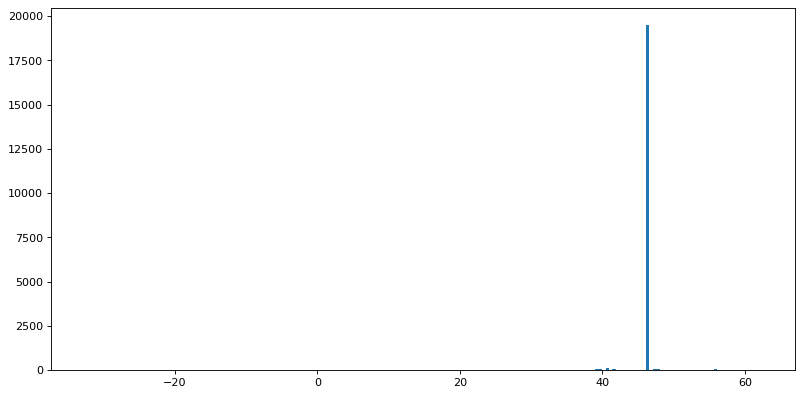

In [40]:
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)

plt.hist(nodes_info['lat'], bins=200)
plt.show()

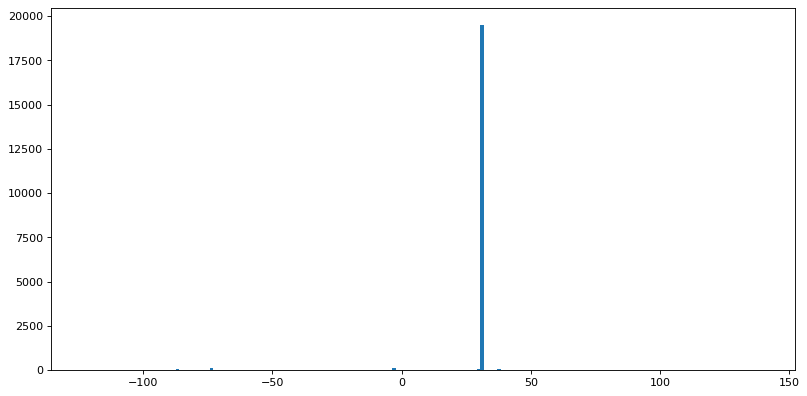

In [41]:
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)

plt.hist(nodes_info['lon'], bins=200)
plt.show()

In [42]:
LON_EPS = 1
LAT_EPS = 1

In [43]:
anomally_nodes = nodes_info[(nodes_info['lat'] < 46.46 - LAT_EPS) | (nodes_info['lat'] > 46.46 + LAT_EPS) | (nodes_info['lon'] > 30.727 + LON_EPS) | (nodes_info['lon'] < 30.727 - LON_EPS)]

In [44]:
anomally_nodes[anomally_nodes['visible'] == 1]

,lat,lon,visible,relations_count,ways_count
node_id,,,,,
8952388922,40.786517,-73.288602,1,0,0
8952388923,40.786337,-73.288494,1,0,0
8952388924,40.785681,-73.288509,1,0,0
8952388925,40.785457,-73.288516,1,0,0
8952388926,40.785293,-73.288538,1,0,0
...,...,...,...,...,...
8952486104,-18.493081,-49.023335,1,0,0
8952486105,-18.493129,-49.023348,1,0,0
8952486106,-18.493167,-49.023381,1,0,0


In [45]:
anomally_nodes.to_csv('anomaly_nodes_info.csv')

In [46]:
anomally_nodes.index

Int64Index([8952388922, 8952388923, 8952388924, 8952388925, 8952388926,
            8952388927, 8952388928, 8952388958, 8952388959, 8952388960,
            ...
            8952483295, 8952483296, 8952485346, 8952485604, 8952486103,
            8952486104, 8952486105, 8952486106, 8952486393, 8952486639],
           dtype='int64', name='node_id', length=868)

In [47]:
paths_anomal_nodes = nodes[nodes['node_start'].isin(anomally_nodes.index) | nodes['node_finish'].isin(anomally_nodes.index)]

In [48]:
len(paths_anomal_nodes['Id'].unique())

4447

In [49]:
len(nodes['Id'].unique())

6000

In [50]:
orders = pd.read_csv('orders.csv')

In [51]:
orders.describe()

,Id,route_distance_km,delta_time
count,5.000000e+03,5000.000000,5000.000000
mean,1.437166e+17,3.705945,613.161600
std,5.322209e+18,1.767206,213.802608
min,-9.220688e+18,0.000000,50.000000
25%,-4.422074e+18,2.359750,441.000000
50%,1.826612e+17,3.394000,614.000000
75%,4.817401e+18,4.753250,788.000000
max,9.222287e+18,15.954000,999.000000


In [52]:
target_id = orders['Id'][0]
target_id

-4773019581999572651

In [53]:
target_nodes = nodes[nodes['Id'] == target_id]

In [54]:
target_nodes

,Id,node_start,node_finish,distance,speed
173285,-4773019581999572651,10980417,4768348185,31.771489,30.0
173286,-4773019581999572651,10980418,1570776947,3.673054,24.0
173287,-4773019581999572651,10980430,4768348188,15.550612,27.0
173288,-4773019581999572651,10980431,5125489557,50.034390,29.0
173289,-4773019581999572651,10980432,5213300015,13.453126,30.0
...,...,...,...,...,...
173386,-4773019581999572651,8047405750,1570776819,14.094747,37.0
173387,-4773019581999572651,8952401429,2133368070,11.411172,27.0
173388,-4773019581999572651,8952405781,1976889231,31.708492,17.0
173389,-4773019581999572651,8952407019,1901714249,4.528134,35.0


In [55]:
nodes_info.loc[target_nodes['node_start'], ['lat', 'lon']]

,lat,lon
node_id,,
10980417,46.468524,30.738275
10980418,46.469605,30.738516
10980430,46.469587,30.738802
10980431,46.471232,30.739016
10980432,46.472665,30.739248
...,...,...
8047405750,46.467779,30.737696
8952401429,38.051872,-122.510810
8952405781,47.488381,-3.107194


In [56]:
target_nodes = target_nodes.join(nodes_info.loc[target_nodes['node_start'], ['lat', 'lon']], on='node_start', rsuffix='node_start')
target_nodes = target_nodes.rename({'lat': 'node_start_lat', 'lon': 'node_start_lon'}, axis=1)
target_nodes

,Id,node_start,node_finish,distance,speed,node_start_lat,node_start_lon
173285,-4773019581999572651,10980417,4768348185,31.771489,30.0,46.468524,30.738275
173286,-4773019581999572651,10980418,1570776947,3.673054,24.0,46.469605,30.738516
173287,-4773019581999572651,10980430,4768348188,15.550612,27.0,46.469587,30.738802
173288,-4773019581999572651,10980431,5125489557,50.034390,29.0,46.471232,30.739016
173289,-4773019581999572651,10980432,5213300015,13.453126,30.0,46.472665,30.739248
...,...,...,...,...,...,...,...
173386,-4773019581999572651,8047405750,1570776819,14.094747,37.0,46.467779,30.737696
173387,-4773019581999572651,8952401429,2133368070,11.411172,27.0,38.051872,-122.510810
173388,-4773019581999572651,8952405781,1976889231,31.708492,17.0,47.488381,-3.107194
173389,-4773019581999572651,8952407019,1901714249,4.528134,35.0,47.559999,-3.135353


In [57]:
target_nodes = target_nodes.join(nodes_info.loc[target_nodes['node_finish'], ['lat', 'lon']], on='node_finish', rsuffix='node_start')
target_nodes = target_nodes.rename({'lat': 'node_finish_lat', 'lon': 'node_finish_lon'}, axis=1)
target_nodes

,Id,node_start,node_finish,distance,speed,node_start_lat,node_start_lon,node_finish_lat,node_finish_lon
173285,-4773019581999572651,10980417,4768348185,31.771489,30.0,46.468524,30.738275,46.468266,30.738097
173286,-4773019581999572651,10980418,1570776947,3.673054,24.0,46.469605,30.738516,46.469551,30.738576
173287,-4773019581999572651,10980430,4768348188,15.550612,27.0,46.469587,30.738802,46.477225,30.724000
173288,-4773019581999572651,10980431,5125489557,50.034390,29.0,46.471232,30.739016,46.470784,30.738957
173289,-4773019581999572651,10980432,5213300015,13.453126,30.0,46.472665,30.739248,46.472545,30.739226
...,...,...,...,...,...,...,...,...,...
173386,-4773019581999572651,8047405750,1570776819,14.094747,37.0,46.467779,30.737696,46.467674,30.737593
173387,-4773019581999572651,8952401429,2133368070,11.411172,27.0,38.051872,-122.510810,46.472783,30.739266
173388,-4773019581999572651,8952405781,1976889231,31.708492,17.0,47.488381,-3.107194,46.458315,30.729720
173389,-4773019581999572651,8952407019,1901714249,4.528134,35.0,47.559999,-3.135353,46.475530,30.739691


In [58]:
target_nodes.to_csv('some_trajetory.csv')

In [59]:
len(nodes[nodes['node_start'].isin(anomally_nodes.index) | nodes['node_finish'].isin(anomally_nodes.index)])/len(nodes)

0.08149642612499505

In [60]:
import math

In [79]:
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6369 * c
    return km

In [125]:
def haversine_row(row):
    lon1 = row['node_start_lon']
    lat1 = row['node_start_lat']
    lon2 = row['node_finish_lon']
    lat2 = row['node_finish_lat']
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6369 * c
    return km

In [126]:
target_nodes['haversine'] = target_nodes.apply(haversine_row, axis = 1)*1000

In [64]:
target_nodes

,Id,node_start,node_finish,distance,speed,node_start_lat,node_start_lon,node_finish_lat,node_finish_lon,haversine
173285,-4773019581999572651,10980417,4768348185,31.771489,30.0,46.468524,30.738275,46.468266,30.738097,3.172590e+01
173286,-4773019581999572651,10980418,1570776947,3.673054,24.0,46.469605,30.738516,46.469551,30.738576,7.488213e+00
173287,-4773019581999572651,10980430,4768348188,15.550612,27.0,46.469587,30.738802,46.477225,30.724000,1.415887e+03
173288,-4773019581999572651,10980431,5125489557,50.034390,29.0,46.471232,30.739016,46.470784,30.738957,4.997853e+01
173289,-4773019581999572651,10980432,5213300015,13.453126,30.0,46.472665,30.739248,46.472545,30.739226,1.346909e+01
...,...,...,...,...,...,...,...,...,...,...
173386,-4773019581999572651,8047405750,1570776819,14.094747,37.0,46.467779,30.737696,46.467674,30.737593,1.411874e+01
173387,-4773019581999572651,8952401429,2133368070,11.411172,27.0,38.051872,-122.510810,46.472783,30.739266,1.024252e+07
173388,-4773019581999572651,8952405781,1976889231,31.708492,17.0,47.488381,-3.107194,46.458315,30.729720,2.548697e+06
173389,-4773019581999572651,8952407019,1901714249,4.528134,35.0,47.559999,-3.135353,46.475530,30.739691,2.549635e+06


In [65]:
filtered_target_nodes = target_nodes[target_nodes['haversine'] < 10 * target_nodes['distance']]

In [66]:
filtered_target_nodes.to_csv('some_trajetory_filtered.csv')

In [67]:
unique_points = np.unique(np.append(filtered_target_nodes['node_start'], filtered_target_nodes['node_finish']))

In [68]:
len(unique_points)

103

In [69]:
unique_points_df = nodes_info.loc[unique_points, ['lat', 'lon']]

In [70]:
unique_points_df

,lat,lon
node_id,,
10980417,46.468524,30.738275
10980418,46.469605,30.738516
10980430,46.469587,30.738802
10980431,46.471232,30.739016
10980432,46.472665,30.739248
...,...,...
7825374441,46.459111,30.729736
7825374442,46.459263,30.729854
8018283981,46.482517,30.740571


In [80]:
def compute_euclidean_distance_matrix(df):
    """Creates callback to return distance between points."""
    distances = np.zeros((len(df), len(df)))
    for i_start in range(len(df)):
        for i_finish in range(i_start + 1, len(df)):
            distances[i_start][i_finish] = (haversine(df.iloc[i_start]['lat'], df.iloc[i_start]['lon'], df.iloc[i_finish]['lat'], df.iloc[i_finish]['lon']))
            distances[i_finish][i_start] = distances[i_start][i_finish]
    return distances

In [81]:
distance_matrix = compute_euclidean_distance_matrix(unique_points_df)

In [96]:
sequences = [[unique_points_df.index[0]]]
used_points = {unique_points_df.index[0]}
unused_points = set(unique_points_df.index[1:])
sequence_id = 0
head = True
while True:
    if len(unused_points) == 0:
        break
    if head:
        current = sequences[sequence_id][0]
        previous = filtered_target_nodes[filtered_target_nodes['node_finish'] == current]['node_start'].values
        if len(previous) > 1:
            raise Exception("More then 1 prev point")
        elif len(previous) == 1:
            sequences[sequence_id].insert(0, previous[0])
            used_points.add(previous[0])
            unused_points.remove(previous[0])
        else:
            head = False
    else:
        current = sequences[sequence_id][-1]
        next = filtered_target_nodes[filtered_target_nodes['node_start'] == current]['node_finish'].values
        if len(next) > 1:
            raise Exception("More then 1 next point")
        elif len(next) == 1:
            sequences[sequence_id].append(next[0])
            unused_points.remove(next[0])
            used_points.add(next[0])
        else:
            # print("Created sequence: ", sequences[sequence_id])
            sequence_id += 1
            new_el = unused_points.pop()
            used_points.add(new_el)
            sequences.append([new_el])
            head = True

Created sequence:  [1746751148, 10980418, 1570776947, 4843855239, 10980417, 4768348185, 5596871317, 290262748]
Created sequence:  [2133368070, 10980432, 5213300015, 4980717063, 3930075242, 5966970977, 2133368096, 10980431, 5125489557, 5213300069, 5596871747, 10980430]
Created sequence:  [8047405750, 1570776819, 6583283285, 4543514608, 5214555660, 6583283185, 2421901608, 1570776789, 1570776788, 4786186029, 4768391694, 4768391695, 4768391696, 2421925794, 1455814099, 4786018123, 4786018211, 4786018203, 4786018208, 4845924947, 1455816519, 4916960069, 4916960075, 4916960076, 3910696309, 5214584828, 316686113, 5214584827, 4768432786, 7825374442, 7825374441, 1751477830, 1751477828, 5214584825, 27128863]
Created sequence:  [4441087529, 4441087526, 4325099311, 290891853, 4441087524, 4441087523, 4441087522, 4325099309, 10980544, 4325099308, 8018283983, 4439629628, 4439629627, 5213015315, 4439629625, 4439629624, 5213015316, 8018283981, 290007862, 2940383471, 5213015320, 4439629610, 4439629599, 10

In [97]:
interseq_distances = np.zeros((len(sequences), len(sequences))) # interseq[i][j] is distance between i-th end and j-th start
for i in range(len(sequences)):
    start_of_seq_i = sequences[i][0]
    end_of_seq_i = sequences[i][-1]
    for j in range(i, len(sequences)):
        if i == j:
            interseq_distances[i][j] = float('inf')
        else:
            start_of_seq_j = sequences[j][0]
            end_of_seq_j = sequences[j][-1]
            interseq_distances[i][j] = haversine(unique_points_df.loc[end_of_seq_i, 'lat'], 
                                                unique_points_df.loc[end_of_seq_i, 'lon'], 
                                                unique_points_df.loc[start_of_seq_j, 'lat'], 
                                                unique_points_df.loc[start_of_seq_j, 'lon'])
            interseq_distances[j][i] = haversine(unique_points_df.loc[start_of_seq_i, 'lat'], 
                                                unique_points_df.loc[start_of_seq_i, 'lon'], 
                                                unique_points_df.loc[end_of_seq_j, 'lat'], 
                                                unique_points_df.loc[end_of_seq_j, 'lon'])
interseq_distances

array([[       inf, 0.56612058, 0.00320008, 1.7485361 , 1.21964785,
        0.71449731, 0.87207712],
       [0.01931268,        inf, 0.21809759, 1.55651849, 1.43305572,
        0.50605464, 0.66407782],
       [1.41460291, 1.75363901,        inf, 2.83294057, 0.03439232,
        1.89484363, 2.04579162],
       [0.7442078 , 0.38661911, 0.95439814,        inf, 2.13699488,
        0.2375949 , 0.07957052],
       [1.53378158, 1.88886099, 1.32086957, 3.03155033,        inf,
        2.03614411, 2.19258085],
       [0.39861726, 0.04085858, 0.60973416, 1.16932744, 1.80541988,
               inf, 0.26619   ],
       [0.57378952, 0.21614253, 0.78434179, 1.00173092, 1.97290461,
        0.06711832,        inf]])

In [98]:
seq_count = len(sequences)
while seq_count > 1:
    first, second = np.unravel_index(interseq_distances.argmin(), interseq_distances.shape)
    sequences[first].extend(sequences[second])
    interseq_distances[first] = interseq_distances[second]
    interseq_distances[second] = float('inf')
    interseq_distances[:, second] = float('inf')
    interseq_distances[first, first] = float('inf')
    seq_count -= 1

0 2
1 0
1 4
5 1
6 5
3 6


3 6 5 1 0 2 4

In [100]:
len(sequences[first])

103

In [101]:
sequences[first][0]

4441087529

In [102]:
sequences[first][-1]

6806370970

In [191]:
sorted_df = pd.DataFrame({'node_id': np.zeros(len(unique_points_df)), 'lat': 0, 'lon': 0})

for i, node_id in enumerate(sequences[first]):
    sorted_df.iloc[i] = [node_id, unique_points_df.loc[node_id, 'lat'], unique_points_df.loc[node_id, 'lon']]

import plotly.express as px

fig = px.line_mapbox(unique_points_df, lat="lat", lon="lon", zoom=3, height=300)

fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=4, mapbox_center_lat = 41,
    margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [111]:
orders.head()

,Id,running_time,completed_time,route_distance_km,delta_time
0,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.740,862.0
1,-7575630690398473489,2022-01-24 06:53:53,2022-01-24 07:06:26,3.526,753.0
2,-6264582368520213833,2022-01-24 10:00:59,2022-01-24 10:15:58,5.071,899.0
3,5964315354301636538,2022-01-24 14:28:05,2022-01-24 14:35:08,2.867,423.0
4,1372379574816145639,2022-01-24 11:57:29,2022-01-24 12:06:29,3.751,540.0


In [222]:
nodes_info.loc[8952432742]

lat                46.468524
lon                30.738275
visible             1.000000
relations_count     0.000000
ways_count          0.000000
Name: 8952432742, dtype: float64

In [113]:
max_lon = 30.862736
min_lon = 30.511882
max_lat = 46.618659
min_lat = 46.296001

valid_nodes_info = nodes_info[((nodes_info['lon'] > min_lon) & (nodes_info['lon'] < max_lon) & (nodes_info['lat'] > min_lat) & (nodes_info['lat'] < max_lat))]
valid_nodes_info

,lat,lon,visible,relations_count,ways_count
node_id,,,,,
10980417,46.468524,30.738275,1,0,3
10980418,46.469605,30.738516,1,0,2
10980419,46.469758,30.736733,1,0,4
10980421,46.471836,30.730899,1,0,2
10980422,46.473256,30.731101,1,0,2
...,...,...,...,...,...
8952432738,46.468524,30.738275,1,0,0
8952432739,46.468524,30.738275,1,0,0
8952432740,46.468524,30.738275,1,0,0


In [121]:
filtered_nodes = nodes[(nodes['node_start'].isin(valid_nodes_info.index)) & (nodes['node_finish'].isin(valid_nodes_info.index))]
filtered_nodes

,Id,node_start,node_finish,distance,speed
0,-2627062893189810184,10980432,2133368107,17.414917,32.0
1,-2627062893189810184,10980433,5212387954,17.186539,26.0
2,-2627062893189810184,10980445,5221700954,28.513481,26.0
3,-2627062893189810184,10980498,10980445,154.266122,25.0
4,-2627062893189810184,10980647,1986137911,8.542824,29.0
...,...,...,...,...,...
480281,-8229597404562288405,4439629611,317187499,157.791878,19.0
480282,-8229597404562288405,4768348190,7113286188,50.972612,21.0
480283,-8229597404562288405,4768348195,4768348190,89.120989,22.0
480284,-8229597404562288405,4768348532,4768348195,116.657109,25.0


In [220]:
valid_nodes_info.to_csv('valid_nodes_info.csv')

In [123]:
filtered_nodes = filtered_nodes.join(valid_nodes_info.loc[filtered_nodes['node_start'].unique(), ['lat', 'lon']], on='node_start', rsuffix='node_start')
filtered_nodes = filtered_nodes.rename({'lat': 'node_start_lat', 'lon': 'node_start_lon'}, axis=1)
filtered_nodes

,Id,node_start,node_finish,distance,speed,node_start_lat,node_start_lon
0,-2627062893189810184,10980432,2133368107,17.414917,32.0,46.472665,30.739248
1,-2627062893189810184,10980433,5212387954,17.186539,26.0,46.472507,30.741320
2,-2627062893189810184,10980445,5221700954,28.513481,26.0,46.472086,30.747110
3,-2627062893189810184,10980498,10980445,154.266122,25.0,46.471949,30.749114
4,-2627062893189810184,10980647,1986137911,8.542824,29.0,46.473095,30.753937
...,...,...,...,...,...,...,...
480281,-8229597404562288405,4439629611,317187499,157.791878,19.0,46.481959,30.719659
480282,-8229597404562288405,4768348190,7113286188,50.972612,21.0,46.472319,30.719530
480283,-8229597404562288405,4768348195,4768348190,89.120989,22.0,46.471727,30.718746
480284,-8229597404562288405,4768348532,4768348195,116.657109,25.0,46.470939,30.717741


In [124]:
filtered_nodes = filtered_nodes.join(valid_nodes_info.loc[filtered_nodes['node_finish'].unique(), ['lat', 'lon']], on='node_finish', rsuffix='node_finish')
filtered_nodes = filtered_nodes.rename({'lat': 'node_finish_lat', 'lon': 'node_finish_lon'}, axis=1)
filtered_nodes

,Id,node_start,node_finish,distance,speed,node_start_lat,node_start_lon,node_finish_lat,node_finish_lon
0,-2627062893189810184,10980432,2133368107,17.414917,32.0,46.472665,30.739248,46.472682,30.739022
1,-2627062893189810184,10980433,5212387954,17.186539,26.0,46.472507,30.741320,46.472524,30.741097
2,-2627062893189810184,10980445,5221700954,28.513481,26.0,46.472086,30.747110,46.472114,30.746740
3,-2627062893189810184,10980498,10980445,154.266122,25.0,46.471949,30.749114,46.472086,30.747110
4,-2627062893189810184,10980647,1986137911,8.542824,29.0,46.473095,30.753937,46.473020,30.753921
...,...,...,...,...,...,...,...,...,...
480281,-8229597404562288405,4439629611,317187499,157.791878,19.0,46.481959,30.719659,46.483349,30.719247
480282,-8229597404562288405,4768348190,7113286188,50.972612,21.0,46.472319,30.719530,46.472664,30.719968
480283,-8229597404562288405,4768348195,4768348190,89.120989,22.0,46.471727,30.718746,46.472319,30.719530
480284,-8229597404562288405,4768348532,4768348195,116.657109,25.0,46.470939,30.717741,46.471727,30.718746


In [127]:
filtered_nodes['haversine'] = filtered_nodes.apply(haversine_row, axis = 1)*1000

In [129]:
filtered_nodes = filtered_nodes[np.abs(filtered_nodes['haversine'] - filtered_nodes['distance']) < 50]
filtered_nodes

,Id,node_start,node_finish,distance,speed,node_start_lat,node_start_lon,node_finish_lat,node_finish_lon,haversine
0,-2627062893189810184,10980432,2133368107,17.414917,32.0,46.472665,30.739248,46.472682,30.739022,17.396263
1,-2627062893189810184,10980433,5212387954,17.186539,26.0,46.472507,30.741320,46.472524,30.741097,17.191515
2,-2627062893189810184,10980445,5221700954,28.513481,26.0,46.472086,30.747110,46.472114,30.746740,28.511460
3,-2627062893189810184,10980498,10980445,154.266122,25.0,46.471949,30.749114,46.472086,30.747110,154.161963
4,-2627062893189810184,10980647,1986137911,8.542824,29.0,46.473095,30.753937,46.473020,30.753921,8.457294
...,...,...,...,...,...,...,...,...,...,...
480281,-8229597404562288405,4439629611,317187499,157.791878,19.0,46.481959,30.719659,46.483349,30.719247,157.739925
480282,-8229597404562288405,4768348190,7113286188,50.972612,21.0,46.472319,30.719530,46.472664,30.719968,50.927187
480283,-8229597404562288405,4768348195,4768348190,89.120989,22.0,46.471727,30.718746,46.472319,30.719530,89.050765
480284,-8229597404562288405,4768348532,4768348195,116.657109,25.0,46.470939,30.717741,46.471727,30.718746,116.585938


In [138]:
orders['sequence'] = ["[]" for _ in range(len(orders))]

In [139]:
orders

,Id,running_time,completed_time,route_distance_km,delta_time,sequence
0,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.740,862.0,[]
1,-7575630690398473489,2022-01-24 06:53:53,2022-01-24 07:06:26,3.526,753.0,[]
2,-6264582368520213833,2022-01-24 10:00:59,2022-01-24 10:15:58,5.071,899.0,[]
3,5964315354301636538,2022-01-24 14:28:05,2022-01-24 14:35:08,2.867,423.0,[]
4,1372379574816145639,2022-01-24 11:57:29,2022-01-24 12:06:29,3.751,540.0,[]
...,...,...,...,...,...,...
4995,7096714159023973792,2022-01-24 21:10:38,2022-01-24 21:23:53,7.397,795.0,[]
4996,-3836026425968071806,2022-01-24 15:10:27,2022-01-24 15:20:21,1.948,594.0,[]
4997,2926216435675216636,2022-01-24 13:57:04,2022-01-24 14:03:18,2.547,374.0,[]
4998,-6677307480063489707,2022-01-24 08:46:13,2022-01-24 08:55:34,3.013,561.0,[]


In [216]:
for id, order in tqdm.tqdm(orders.iterrows()):
    filtered_nodes_order = filtered_nodes[filtered_nodes['Id'] == order['Id']]
    unique_points = np.unique(np.append(filtered_nodes_order['node_start'], filtered_nodes_order['node_finish']))
    unique_points_df = nodes_info.loc[unique_points, ['lat', 'lon']]
    unique_points_df['start_count'] = filtered_nodes_order['node_start'].value_counts()
    unique_points_df['finish_count'] = filtered_nodes_order['node_finish'].value_counts()
    unique_points_df['start_count'] = unique_points_df['start_count'].fillna(0)
    unique_points_df['finish_count'] = unique_points_df['finish_count'].fillna(0)

    if len(unique_points_df) == 0:
        orders.loc[id, 'sequence'] = "Zero normal points"
        continue

    repeating_points = unique_points_df[(unique_points_df['start_count'] > 1) | (unique_points_df['finish_count'] > 1)]

    sequences = [[unique_points_df.index[0]]]
    used_points = {unique_points_df.index[0]}
    unused_points = set(unique_points_df.index[1:])
    # for point_id, point_row in repeating_points.iterrows:
    #     count = max(point_row['start_count'], point_row['finish_count'])
    #     for i in range(1, count):
    #         unused_points.add(point_id + i/count)

    sequence_id = 0
    head = True
    try:
        while True:
            if len(unused_points) == 0:
                break
            if head:
                current = sequences[sequence_id][0]
                previous = filtered_nodes_order[filtered_nodes_order['node_finish'] == current]['node_start'].values
                if len(previous) > 1:
                    head = False
                    # distances = []
                    # for point in previous:
                    #     if point in repeating_points.index:
                    #         count = max(repeating_points.loc[point, 'start_count'], repeating_points.loc[point, 'finish_count'])
                    #         is_place = False
                    #         for i in range(count):
                    #             if point + i/count in unused_points:
                    #                 is_place = True
                    #                 break
                    #         if not is_place:
                    #             distances.append(float('inf'))
                    #             continue
                    #     else:
                    #         if point not in unused_points:
                    #             distances.append(float('inf'))
                    #             continue
                    #     distances.append(haversine(unique_points_df.loc[current, 'lat'], 
                    #                                 unique_points_df.loc[current, 'lon'], 
                    #                                 unique_points_df.loc[point, 'lat'], 
                    #                                 unique_points_df.loc[point, 'lon']))
                    # min_distance = np.min(distances)
                    # if min_distance < float('inf'):
                    #     argmin_dist = np.argmin(distances)
                    #     sequences[sequence_id].insert(0, previous[argmin_dist])

                    #     count = max(unique_points_df.loc[point, 'start_count'], unique_points_df.loc[point, 'finish_count'])
                    #     for i in range(count):
                            
                    #     used_points.add(previous[0])
                    #     unused_points.remove(previous[0])
                    # else:
                    #     head = False
                elif len(previous) == 1:
                    sequences[sequence_id].insert(0, previous[0])
                    used_points.add(previous[0])
                    unused_points.remove(previous[0])
                else:
                    head = False
            else:
                current = sequences[sequence_id][-1]
                next = filtered_nodes_order[filtered_nodes_order['node_start'] == current]['node_finish'].values
                if len(next) > 1:
                    sequence_id += 1
                    new_el = unused_points.pop()
                    used_points.add(new_el)
                    sequences.append([new_el])
                    head = True
                    # print("Created sequence: ", sequences[sequence_id])
                    # raise Exception("More then 1 next point")
                elif len(next) == 1:
                    sequences[sequence_id].append(next[0])
                    unused_points.remove(next[0])
                    used_points.add(next[0])
                else:
                    # print("Created sequence: ", sequences[sequence_id])
                    sequence_id += 1
                    new_el = unused_points.pop()
                    used_points.add(new_el)
                    sequences.append([new_el])
                    head = True
    except Exception as e:
        orders.loc[id, 'sequence'] = str(e)
        # print(e)
        continue

    interseq_distances = np.zeros((len(sequences), len(sequences))) # interseq[i][j] is distance between i-th end and j-th start
    for i in range(len(sequences)):
        start_of_seq_i = sequences[i][0]
        end_of_seq_i = sequences[i][-1]
        for j in range(i, len(sequences)):
            if i == j:
                interseq_distances[i][j] = float('inf')
            else:
                start_of_seq_j = sequences[j][0]
                end_of_seq_j = sequences[j][-1]
                interseq_distances[i][j] = haversine(unique_points_df.loc[end_of_seq_i, 'lat'], 
                                                    unique_points_df.loc[end_of_seq_i, 'lon'], 
                                                    unique_points_df.loc[start_of_seq_j, 'lat'], 
                                                    unique_points_df.loc[start_of_seq_j, 'lon'])
                interseq_distances[j][i] = haversine(unique_points_df.loc[start_of_seq_i, 'lat'], 
                                                    unique_points_df.loc[start_of_seq_i, 'lon'], 
                                                    unique_points_df.loc[end_of_seq_j, 'lat'], 
                                                    unique_points_df.loc[end_of_seq_j, 'lon'])
    
    seq_count = len(sequences)
    first = 0
    while seq_count > 1:
        first, second = np.unravel_index(interseq_distances.argmin(), interseq_distances.shape)
        sequences[first].extend(sequences[second])
        interseq_distances[first] = interseq_distances[second]
        interseq_distances[second] = float('inf')
        interseq_distances[:, second] = float('inf')
        interseq_distances[first, first] = float('inf')
        seq_count -= 1

    orders.loc[id, 'sequence'] = str(sequences[first])


26it [00:01, 21.81it/s]


In [209]:
sorted_df = pd.DataFrame({'node_id': np.zeros(len(unique_points_df)), 'lat': 0, 'lon': 0})

for i, node_id in enumerate(eval(orders.loc[3912, 'sequence'])):
    sorted_df.iloc[i] = [node_id, unique_points_df.loc[node_id, 'lat'], unique_points_df.loc[node_id, 'lon']]

import plotly.express as px

fig = px.line_mapbox(sorted_df, lat="lat", lon="lon", zoom=3, height=300)

fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=4, mapbox_center_lat = 41,
    margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [197]:
eval(orders.loc[3912, 'sequence'])

[8952426168,
 8952426164,
 3344709913,
 321367731,
 321367693,
 4762038090,
 321367730,
 321367465,
 4712363592,
 4488929053,
 321367466,
 321367526,
 7060127406,
 321367527,
 271326641,
 321366711,
 4475534144,
 4475535214,
 4475535230,
 10980529,
 4475535391,
 4475535420,
 4475535438,
 4475535671,
 3719875491,
 3719875511,
 3719875512,
 5208339857,
 4475535825,
 4628552322,
 4628552324,
 4628552323,
 3719876031,
 290404304,
 10980498,
 10980445,
 5221977182,
 5221977183,
 1901714242,
 4625785799,
 4625785687,
 5222301453,
 4382575812,
 5222301454,
 290404267,
 290404288,
 4625452523,
 290404286,
 3902355677,
 4625318589,
 4625318613,
 4625318588,
 4439629615,
 4439629617,
 4439629618,
 7578135694,
 287688121,
 8018354885,
 4439629631,
 4439629638,
 4439629640,
 4439629641,
 274918417,
 5238124794,
 4630829403,
 4630829408,
 4439629645,
 4325093115,
 274918418,
 5238124966,
 4439629647,
 4439629648,
 1751043133,
 317442798,
 4325093119,
 4439629653,
 4625500016,
 4325093120,
 27128849

In [217]:
orders

,Id,running_time,completed_time,route_distance_km,delta_time,sequence
0,-4773019581999572651,2022-01-24 18:30:21,2022-01-24 18:44:43,3.740,862.0,"[4441087529, 4441087526, 4325099311, 290891853..."
1,-7575630690398473489,2022-01-24 06:53:53,2022-01-24 07:06:26,3.526,753.0,"[4790757673, 4790757674, 4790757672, 290404245..."
2,-6264582368520213833,2022-01-24 10:00:59,2022-01-24 10:15:58,5.071,899.0,"[6806370965, 6806370964, 6806370963, 680637096..."
3,5964315354301636538,2022-01-24 14:28:05,2022-01-24 14:35:08,2.867,423.0,"[988709862, 2072353444, 988709861, 4382736188,..."
4,1372379574816145639,2022-01-24 11:57:29,2022-01-24 12:06:29,3.751,540.0,"[5216935102, 5216935103, 1973798474, 197379847..."
...,...,...,...,...,...,...
4995,7096714159023973792,2022-01-24 21:10:38,2022-01-24 21:23:53,7.397,795.0,"[8952394106, 8952394105, 8952394112, 895239411..."
4996,-3836026425968071806,2022-01-24 15:10:27,2022-01-24 15:20:21,1.948,594.0,27126481
4997,2926216435675216636,2022-01-24 13:57:04,2022-01-24 14:03:18,2.547,374.0,"[317195151, 317190444, 2133368106, 1570777095,..."
4998,-6677307480063489707,2022-01-24 08:46:13,2022-01-24 08:55:34,3.013,561.0,"[320912506, 3358737298, 3358737333, 3358737332..."


In [214]:
orders[orders['sequence'].isin(['Zero normal points', 'More then 1 next point', 'More then 1 prev point'])]

,Id,running_time,completed_time,route_distance_km,delta_time,sequence
1916,-2419401989749837317,2022-01-24 09:30:28,2022-01-24 09:32:20,3.500,112.0,Zero normal points
3430,-3395337991444444556,2022-01-24 20:27:48,2022-01-24 20:40:56,3.686,788.0,Zero normal points
4137,617981316941136554,2022-01-24 15:55:42,2022-01-24 16:01:46,0.540,364.0,Zero normal points


In [177]:
orders[orders['sequence'].isin(['Zero normal points'])]

,Id,running_time,completed_time,route_distance_km,delta_time,sequence
1916,-2419401989749837317,2022-01-24 09:30:28,2022-01-24 09:32:20,3.500,112.0,Zero normal points
3430,-3395337991444444556,2022-01-24 20:27:48,2022-01-24 20:40:56,3.686,788.0,Zero normal points
4137,617981316941136554,2022-01-24 15:55:42,2022-01-24 16:01:46,0.540,364.0,Zero normal points


In [218]:
orders.to_csv('orders_with_sequencesv2.csv')